In [1]:
# Python 2 and 3 compatibility
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

In [2]:
import scipy
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['norm','lognorm','expon', 'powerlaw','pareto', 'chi2','gamma', 'loggamma', 'powernorm']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))

        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p
        
        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
            
    def Plot(self,y):
        x = self.Random(n=len(y))
        plt.hist(x, alpha=0.5, label='Fitted')
        plt.hist(y, alpha=0.5, label='Actual')
        plt.legend(loc='upper right')

In [3]:
import pandas as pd
import numpy as np

from datetime import datetime
import time

from collections import defaultdict
from collections import Counter
from collections import OrderedDict

import pandas_profiling as pp

import matplotlib.pyplot as plt
from matplotlib import dates
from scipy.stats import powerlaw, lognorm, norm 

from sklearn.cluster import KMeans
from sklearn import metrics

%matplotlib inline

from math import log

import sys

In [4]:
df = pd.read_csv("MessageTracking-anon.csv", error_bad_lines=False)

In [5]:
pp.ProfileReport(df)

Number of variables,16
Number of observations,77901
Total Missing (%),28.2%
Total size in memory,9.5 MiB
Average record size in memory,128.0 B
Numeric,3
Categorical,12
Boolean,0
Date,0
Text (Unique),0
Rejected,1


________________________________________________________________________________________________

In [6]:
def emails_days(df):
    days = [str_to_day(s) for s in df['Timestamp'].tolist()]
    return normalize_days(days)

def str_to_day(s):
    return time.mktime(datetime.strptime(s, '%d.%m.%Y %H:%M:%S').timetuple()) // (24 * 60 * 60)

def normalize_days(days):
    min_ = min(days)
    days = [int(ts - min_) for ts in days]
    return days

In [7]:
df.columns = ['Timestamp', 'Sender', 'Recipients', 'MessageSubject', 'InternalMessageId', 'clientid','ConnectorId', 
              'RecipientStatus', 'TotalBytes', 'RecipientCount', 'RelatedRecipientAddress', 
              'Reference', 'ReturnPath', 'MessageInfo', 'EventId', 'MessageId']

In [8]:
spamers = ['5c316fcd8e442c933d6597a609a5c3ab@62144c8c8c29ab916720cf6480112f77']


def delete(source, spamersAll):
    for spamer in spamersAll:
        source = source.replace(spamer, "")
    return source.strip()

df = df[df['MessageSubject'] != 'EMPTY']
df = df[df['Recipients'] != '']
df.loc[:, 'Recipients'] = [delete(recipient, spamers) for recipient in df['Recipients']]
df = df[[sender not in spamers for sender in df['Sender']]]
df = df[df['Recipients'] != '']

df.loc[:, 'Day'] = emails_days(df)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d.%m.%Y %H:%M:%S')

df['hour'] = df['Timestamp'].apply(lambda x: x.hour)
df['day1'] = df['Timestamp'].apply(lambda x: x.day)

In [9]:
df_receive = df[df['EventId'] == 'RECEIVE']
df_deliver = df[df['EventId'] == 'DELIVER']

In [10]:
def distribution(objects):
    result_distribution = defaultdict(int)
    for obj in objects:
        result_distribution[obj] += 1
    return result_distribution
        
def cCDF(distribution):
    result = defaultdict(int)
    sum_ = 0
    
    total_sum = float(sum(distribution.values()))
    
    for key in sorted(distribution.keys()):
        sum_ += distribution[key]
        result[key] = 1 - sum_ / total_sum 

    return result

In [11]:
def get_senders(df):
    return [sender for sender in df['Sender']]

def get_recipients(df):
    return reduce(lambda a, x: a + x, df['Recipients'].map(lambda x: x.split()).tolist(), [])
    

## Какой день 

In [12]:
def Days(df):
    result = defaultdict(list)
    for index, row in df.iterrows():
        sender = row['Sender']
        count = row['day1']
        result[sender].append(count)
    return result

daysCount = Days(df_receive)    

## Часы ответа

In [13]:
def Hours(df):
    result = defaultdict(list)
    for index, row in df.iterrows():
        sender = row['Sender']
        count = row['hour']
        result[sender].append(count)
    return result

hoursCount = Hours(df_receive)    

In [14]:
#h1 = hoursCount.get('cbdf58e49d76188667a090f830325853@8d192ad005fa78b84e4fb97b139c1cef')
#df[df['Sender'] == 'cbdf58e49d76188667a090f830325853@8d192ad005fa78b84e4fb97b139c1cef']['hour'].rolling(17).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)

In [15]:
#559274706de357f105e49769db70bc1c@8d192ad005fa78b84e4fb97b139c1cef
#plt.plot(hoursCount.get('559274706de357f105e49769db70bc1c@8d192ad005fa78b84e4fb97b139c1cef'))

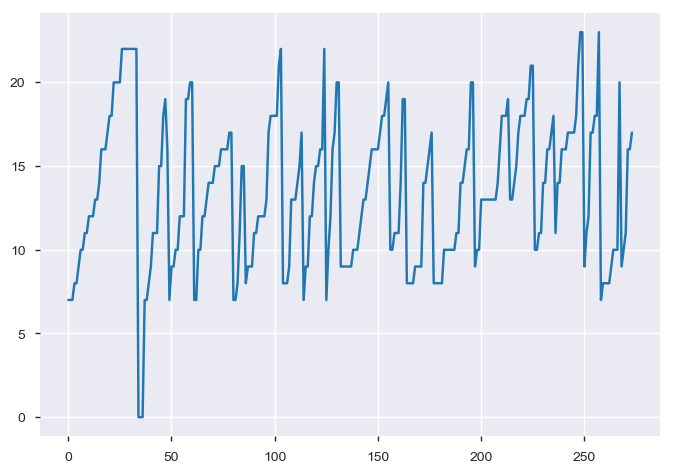

In [15]:
#1aea34ee220806ff38dbb2855368b57a@8d192ad005fa78b84e4fb97b139c1cef
plt.plot(hoursCount.get('1aea34ee220806ff38dbb2855368b57a@8d192ad005fa78b84e4fb97b139c1cef'))

## Размеры письма

In [14]:
mail_distr = defaultdict(int)
scale = 200

for size in df_receive['TotalBytes']:
    mail_distr[(size // scale) * scale] += 1

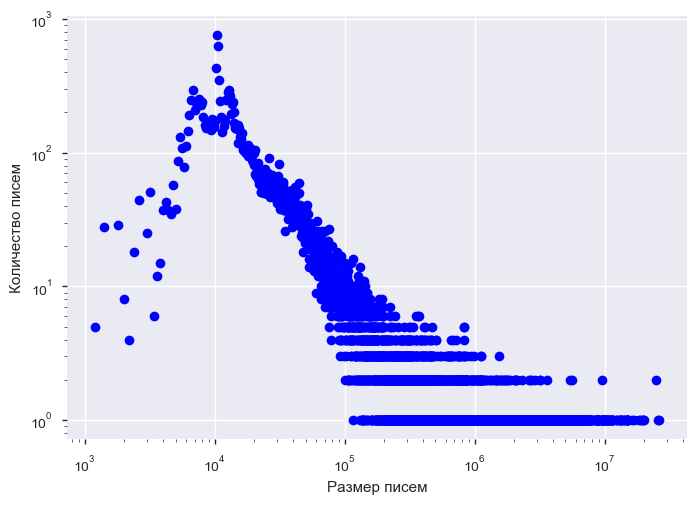

In [15]:
plt.loglog(mail_distr.keys(), mail_distr.values(), 'bo')
plt.ylabel(u"Количество писем")
plt.xlabel(u"Размер писем")
plt.grid(True)
plt.show()

In [16]:
ccdf_ = cCDF(mail_distr)

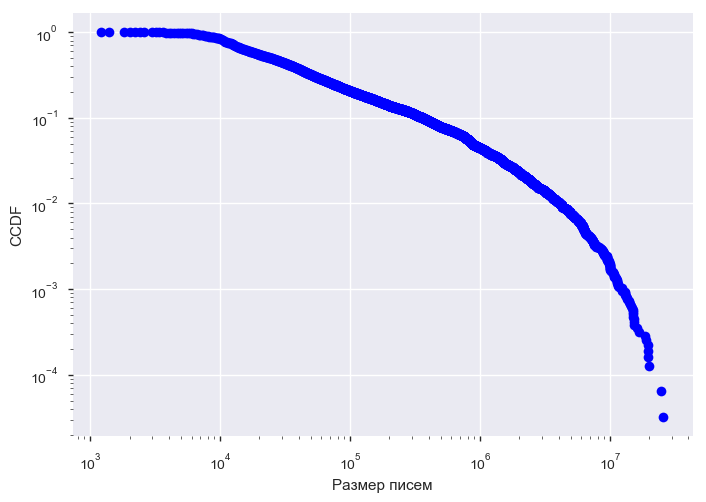

In [17]:
ccdf_ = cCDF(mail_distr)
plt.loglog(ccdf_.keys(), ccdf_.values(), 'bo')
plt.ylabel(u"CCDF")
plt.xlabel(u"Размер писем")
plt.grid(True)
plt.show()

Гистограмма размера электронной имеет пики около 3 КБ и 10 КБ. CCDF размера электронной почты имеет вид степенного распределения, диапазон от 10 КБ до 3 МБ. Большинство писем имеют маленькие размеры, но и немало писем с большим размером

In [18]:
def MailSizes(df):
    result = defaultdict(list)
    for index, row in df.iterrows():
        sender = row['Sender']
        size = row['TotalBytes']
        result[sender].append(size)
    return result

mailSizes = MailSizes(df_receive)

In [19]:
a = []
dst = Distribution()
for k,v in mailSizes.items():
    tmp = v
    tmp1 = dst.Fit(tmp)
    #print (tmp1[0])
    a.append(tmp1[0])
print(max(set(a), key=a.count))   

lognorm


In [20]:
mailSizes_loc = []
mailSizes_scale = []
for k, v in mailSizes.items():
    results = lognorm.fit(mailSizes.get(k))
    mailSizes_loc.append(results[0])
    mailSizes_scale.append(results[1])

In [21]:
mailSizesMean = {}
for sender in mailSizes.keys():
    mailSizesMean[sender] = np.median(mailSizes[sender])

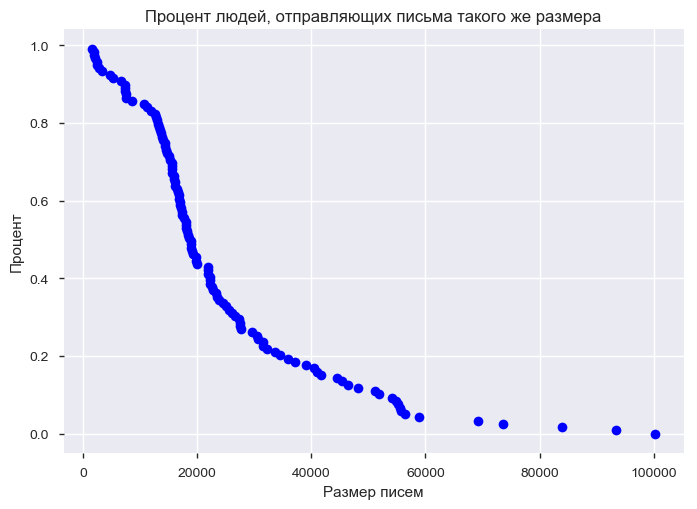

In [22]:
mailSizesCcdf = cCDF(Counter(filter(lambda x: x < 150000, mailSizesMean.values())))

plt.ylabel(u'Процент')
plt.xlabel(u'Размер писем')
plt.title(u'Процент людей, отправляющих письма такого же размера')
plt.grid(True)
plt.plot(mailSizesCcdf.keys(), mailSizesCcdf.values(), 'bo')
plt.show()

NameError: name 'meanPositionInTheThread' is not defined

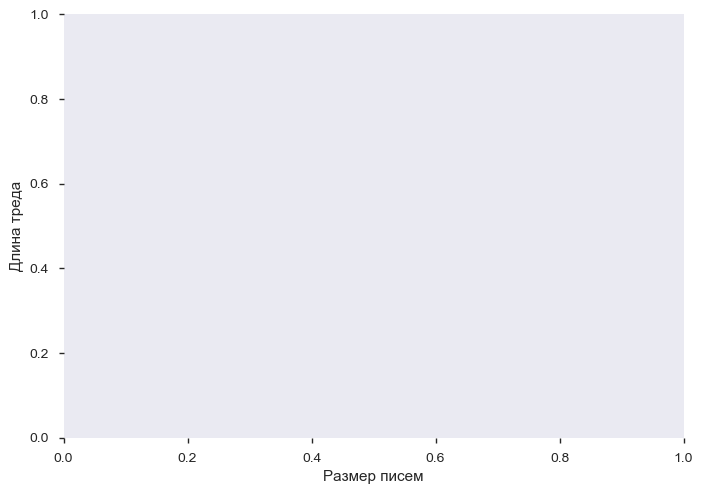

In [25]:
plt.ylabel(u'Длина треда')
plt.xlabel(u'Размер писем')
#plt.title(u'Процент людей, отправляющих письма такого же размера')
plt.grid()
plt.plot(mailSizesMean.values(),meanPositionInTheThread.values(), 'bo')
plt.show()

В среднем отправляют 18Кб данных. ~10% отправляют 6Кб данных или меньше, также ~10% отправляют больше 50Кб.

##  Время ответа

In [23]:
def ReactionTime(df):
    result = defaultdict(list)
    
    subjects = getThreadsSubjects(df)
    for subject in subjects:
        messages = threadMessages(df, subject)
        timestamps = pd.to_datetime(messages['Timestamp'], format='%d.%m.%Y %H:%M:%S')
        senders = messages['Sender']
    
        delays = senderDelays(timestamps, senders)
        for delay in delays:
            result[delay[0]].append(delay[1])
        
    return result

def getThreadsSubjects(df):
    return list(set(df['MessageSubject']))

def threadMessages(df, subject):
    return df[df['MessageSubject'] == subject]

def senderDelays(timestamps, senders):
    senders = senders[1:]
    delays = map(lambda pair: (pair[0] - pair[1]).seconds, zip(timestamps.iloc[1:], timestamps.iloc[:-1]))
    return zip(senders, delays)

senderDelays = ReactionTime(df_receive)


In [31]:
time_distr = defaultdict(int)
#scale = 200

for k,v in senderDelays.items():
    for v1 in v:
        time_distr[v1] += 1

In [33]:
#t = distribution(senderDelays)
ccdf_time = cCDF(time_distr)

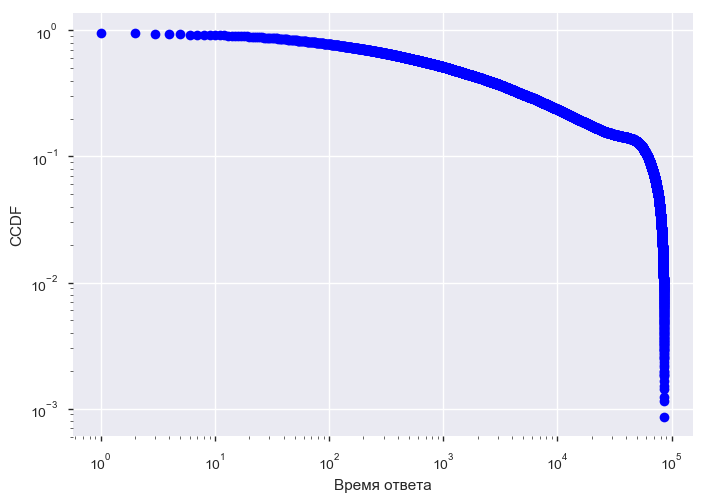

In [35]:
ccdf_time = cCDF(time_distr)
plt.loglog(ccdf_time.keys(), ccdf_time.values(), 'bo')
plt.ylabel(u"CCDF")
plt.xlabel(u"Время ответа")
plt.grid(True)
plt.show()

In [36]:
time = []
dst = Distribution()
for k,v in senderDelays.items():
    tmp = v
    tmp1 = dst.Fit(tmp)
    time.append(tmp1[0])
print(max(set(time), key=time.count))  

lognorm


In [37]:
senderDelays_loc = []
senderDelays_scale = []

for k, v in senderDelays.items():
    results = lognorm.fit(senderDelays.get(k))
    senderDelays_loc.append(results[0])
    senderDelays_scale.append(results[1])

In [38]:
meanSenderDelays = {}
for sender in senderDelays.keys():
    meanSenderDelays[sender] = np.median(senderDelays[sender])

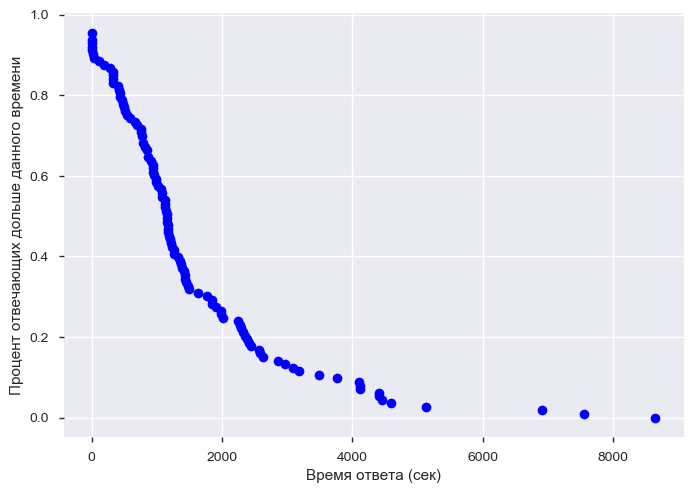

In [39]:
delaysCcdf = cCDF(Counter(filter(lambda delay: delay < 10000, meanSenderDelays.values())))

plt.ylabel(u'Процент отвечающих дольше данного времени')
plt.xlabel(u'Время ответа (сек)')
plt.grid(True)
plt.plot(delaysCcdf.keys(), delaysCcdf.values(), 'bo')
plt.show()

Около 10% людей отвечают в течение часа. Половина пользователей в среднем отвечают в течение 20 минут. Около 20% людей, отвечающих в течение  40 минут после получения письма. 

## Длина треда в момент отправки письма                     

In [40]:
def ThreadSizes(df):
    result = defaultdict(list)
    threads = findThreads(df)
    for thread in findThreads(df):
        indexes = sendIndexesInThread(thread)
        for userIndex in indexes:
            result[userIndex[0]].append(userIndex[1])
    return result

def findThreads(df):
    subjects = getThreadsSubjects(df)
    return [threadMessages(df, subject) for subject in subjects]

def sendIndexesInThread(thread):
    indexes = range(thread.shape[0])
    return zip(thread['Sender'], indexes)
    

PositionInTheThread = ThreadSizes(df_receive)

In [41]:
pos_distr = defaultdict(int)
#scale = 200

for k,v in PositionInTheThread.items():
    for v1 in v:
        pos_distr[v1] += 1

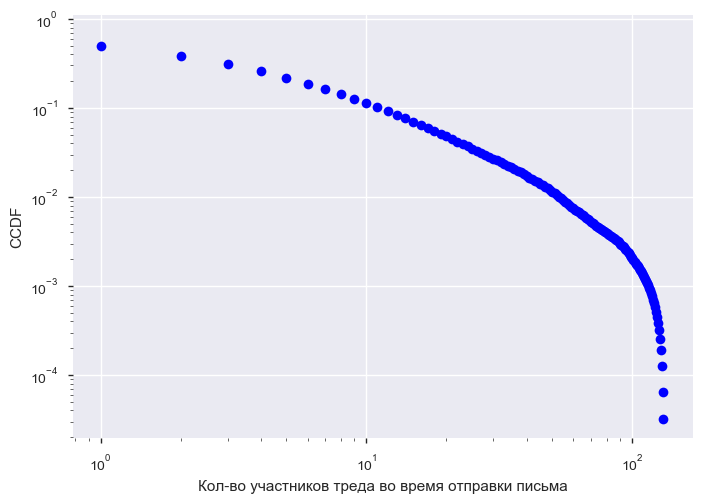

In [42]:
ccdf_pos = cCDF(pos_distr)
plt.loglog(ccdf_pos.keys(), ccdf_pos.values(), 'bo')
plt.ylabel(u"CCDF")
plt.xlabel(u"Кол-во участников треда во время отправки письма")
plt.grid(True)
plt.show()

In [43]:
threadPos = []
dst = Distribution()
for k,v in PositionInTheThread.items():
    tmp = v
    tmp1 = dst.Fit(tmp)
    threadPos.append(tmp1[0])
print(max(set(threadPos), key=threadPos.count))  

norm


In [44]:
PositionInTheThread_loc = []
PositionInTheThread_scale = []
for k, v in PositionInTheThread.items():
    results = lognorm.fit(PositionInTheThread.get(k))
    PositionInTheThread_loc.append(results[0])
    PositionInTheThread_scale.append(results[1])

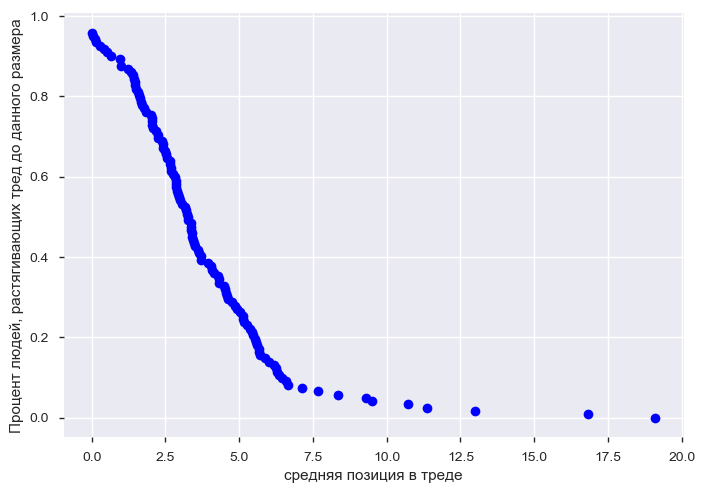

In [45]:
meanPositionInTheThread = {}
for sender in PositionInTheThread.keys():
    meanPositionInTheThread[sender] = np.mean(PositionInTheThread[sender])

positionsCcdf = cCDF(Counter(filter(lambda pos: pos < 30, meanPositionInTheThread.values())))

plt.ylabel(u'Процент людей, растягивающих тред до данного размера')
plt.xlabel(u'средняя позиция в треде')
plt.grid(True)
plt.plot(positionsCcdf.keys(), positionsCcdf.values(), 'bo')
plt.show()

~50% стараются писать в треды не больше 3-4 сообщений. ~20% людей пишут в треды с 5 и больше сообщениями.

## Количество получателей в письме

In [50]:
def RecipientNumber(df):
    result = defaultdict(list)
    for index, row in df.iterrows():
        sender = row['Sender']
        count = row['RecipientCount']
        result[sender].append(count)
    return result

recipientNumberInMails = RecipientNumber(df_receive)    

In [51]:
resN_distr = defaultdict(int)
#scale = 200

for k,v in recipientNumberInMails.items():
    for v1 in v:
        resN_distr[v1] += 1

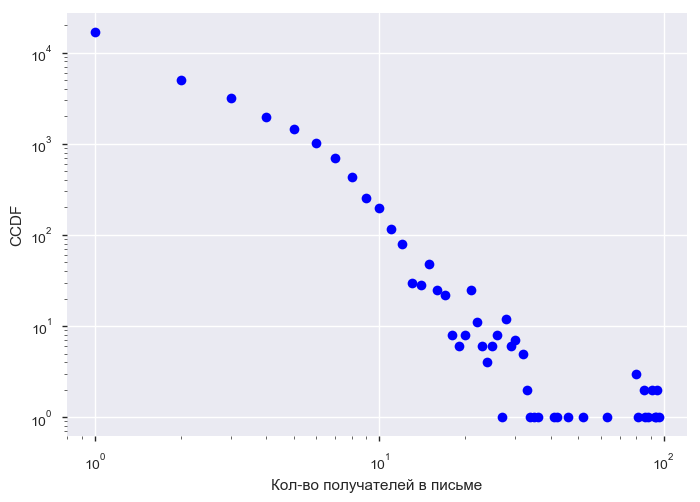

In [52]:
ccdf_res = cCDF(resN_distr)
plt.loglog(resN_distr.keys(), resN_distr.values(), 'bo')
plt.ylabel(u"CCDF")
plt.xlabel(u"Кол-во получателей в письме")
plt.grid(True)
plt.show()

In [53]:
recipientCnt = []
dst = Distribution()
for k,v in recipientNumberInMails.items():
    tmp = v
    tmp1 = dst.Fit(tmp)
    recipientCnt.append(tmp1[0])
print(max(set(recipientCnt), key=recipientCnt.count))  

norm


In [54]:
recipientNumberInMails_loc = []
recipientNumberInMails_scale = []
for k, v in recipientNumberInMails.items():
    results = norm.fit(recipientNumberInMails.get(k))
    recipientNumberInMails_loc.append(results[0])
    recipientNumberInMails_scale.append(results[1])

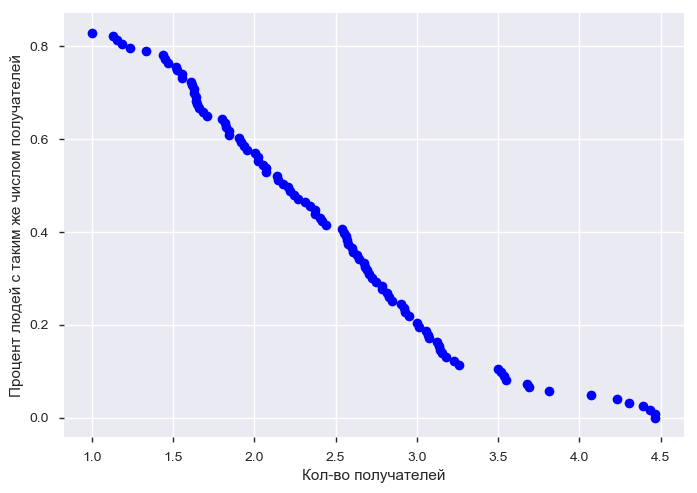

In [55]:
meanrecipientNumberInMails = {}
for sender in recipientNumberInMails.keys():
    meanrecipientNumberInMails[sender] = np.mean(recipientNumberInMails[sender])

recipientsCcdf = cCDF(Counter(filter(lambda pos: pos < 30, meanrecipientNumberInMails.values())))

plt.ylabel(u'Процент людей c таким же числом получателей')
plt.xlabel(u'Кол-во получателей')
plt.grid(True)
plt.plot(recipientsCcdf.keys(), recipientsCcdf.values(), 'bo')
plt.show()

По графику видно, что ~10% людей пишут 4 адресатам и более. Больше 50% людей пишут 2 адресатам.

### Зависимость длины треда от кол-ва людей в треде

Text(0.5,0,'Кол-во людей в треде')

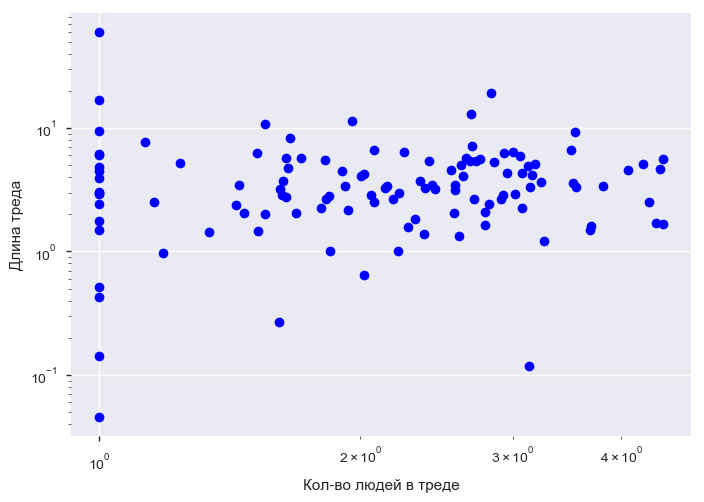

In [56]:
plt.loglog(meanrecipientNumberInMails.values(),meanPositionInTheThread.values(), 'bo')
plt.ylabel('Длина треда')
plt.xlabel('Кол-во людей в треде')

## Данные 

In [57]:
Reactions = map(lambda key: np.mean(senderDelays[key]) ,senderDelays.keys())

Positions = map(lambda key: np.mean(PositionInTheThread[key]) ,PositionInTheThread.keys())

RecipientsNumber = map(lambda key: np.mean(recipientNumberInMails[key]) ,recipientNumberInMails.keys())

MailSizes = map(lambda key: np.mean(mailSizes[key]) ,mailSizes.keys())

Hours = map(lambda key: np.mean(hoursCount[key]) ,hoursCount.keys())

Days = map(lambda key: round(np.mean(daysCount[key])) ,hoursCount.keys())

In [58]:
d = {
    'days': pd.Series(Days, index=daysCount.keys()),
    'hours': pd.Series(Hours, index=hoursCount.keys()),
    'time to answer' : pd.Series(Reactions, index=senderDelays.keys()),
    'time to answer loc' : pd.Series(senderDelays_loc, index=senderDelays.keys()),
    'time to answer scale' : pd.Series(senderDelays_scale, index=senderDelays.keys()),
    'positions in the thread' : pd.Series(Positions, index=PositionInTheThread.keys()),
    'positions in the thread loc' : pd.Series(PositionInTheThread_loc, index=PositionInTheThread.keys()),
    'positions in the thread scale' : pd.Series(PositionInTheThread_scale, index=PositionInTheThread.keys()),
    'recipients number' : pd.Series(RecipientsNumber, index=recipientNumberInMails.keys()),
    'recipients number loc' : pd.Series(recipientNumberInMails_loc, index=recipientNumberInMails.keys()),
    'recipients number scale' : pd.Series(recipientNumberInMails_scale, index=recipientNumberInMails.keys()),
    'mail sizes' : pd.Series(MailSizes, index=mailSizes.keys()),
    'mail sizes loc' : pd.Series(mailSizes_loc, index=mailSizes.keys()),
    'mail sizes scale' : pd.Series(mailSizes_scale, index=mailSizes.keys())
    
}

In [59]:
df_final = pd.DataFrame(d)
df_final = df_final.dropna()

df_final.head()

,days,hours,mail sizes,mail sizes loc,mail sizes scale,positions in the thread,positions in the thread loc,positions in the thread scale,recipients number,recipients number loc,recipients number scale,time to answer,time to answer loc,time to answer scale
0814f7ee8faf3c748540baf83611bc69@8d192ad005fa78b84e4fb97b139c1cef,12.0,12.586957,270269.369565,9.059272,9712.000000,1.000000,2.075391,-4.186036e-06,4.304348,4.304348,3.289440,6515.133333,5.239020,8.100000e+01
08cc8fd0ca7f2d9959c7e383952f7a2b@8d192ad005fa78b84e4fb97b139c1cef,16.0,12.873333,105447.096667,1.245907,4530.541006,3.476667,13.679959,-8.607430e-26,1.803333,1.803333,1.601454,11773.871429,4.383432,-4.383393e-07
0cd4d12b78f52b88563a133f99dbd300@8d192ad005fa78b84e4fb97b139c1cef,14.0,14.042945,244517.368098,1.994480,3955.186920,4.276074,10.878864,-1.166286e-23,2.245399,2.245399,1.658190,10065.417323,2.199666,4.892935e-01
0d5a5ecb4e0af8144a30e899b294bf45@8d192ad005fa78b84e4fb97b139c1cef,14.0,12.692456,35015.818182,1.214338,5220.220462,1.388781,10.092992,-1.376826e-16,2.075435,2.075435,4.976941,28248.062992,7.307274,3.000000e+00
101a5b9ab6c81dd9f6f461423bb2f6b8@8d192ad005fa78b84e4fb97b139c1cef,13.0,13.038462,154965.780220,2.693968,6819.071272,5.601648,7.335930,-2.165835e-23,2.601648,2.601648,3.866324,14076.529183,14.446536,-3.955953e-19


In [60]:
pp.ProfileReport(df_final)

Number of variables,15
Number of observations,118
Total Missing (%),0.0%
Total size in memory,13.9 KiB
Average record size in memory,120.7 B
Numeric,13
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,1


In [61]:
df_full1 = df_final[['days', 'hours','time to answer loc' ,
    'recipients number scale','positions in the thread scale']]

********************************************************************************

In [62]:
X = (df_full1 - df_full1.mean()) / (df_full1.max() - df_full1.min())
X.head()

,days,hours,time to answer loc,recipients number scale,positions in the thread scale
0814f7ee8faf3c748540baf83611bc69@8d192ad005fa78b84e4fb97b139c1cef,-0.201396,-0.012760,0.067966,0.107278,0.022309
08cc8fd0ca7f2d9959c7e383952f7a2b@8d192ad005fa78b84e4fb97b139c1cef,0.033898,0.002407,0.001424,-0.067523,0.022309
0cd4d12b78f52b88563a133f99dbd300@8d192ad005fa78b84e4fb97b139c1cef,-0.083749,0.064349,-0.168414,-0.061648,0.022309
0d5a5ecb4e0af8144a30e899b294bf45@8d192ad005fa78b84e4fb97b139c1cef,-0.083749,-0.007172,0.228820,0.282029,0.022309
101a5b9ab6c81dd9f6f461423bb2f6b8@8d192ad005fa78b84e4fb97b139c1cef,-0.142572,0.011152,0.784061,0.167018,0.022309


In [63]:
range_n_clusters = range(3, 50)

In [64]:
def silhouetteScore(df, n_clusters = 2):
    est = KMeans(n_clusters=n_clusters)
    labels = est.fit_predict(df)
    return metrics.silhouette_score(df, labels)

Text(0,0.5,'silhouette')

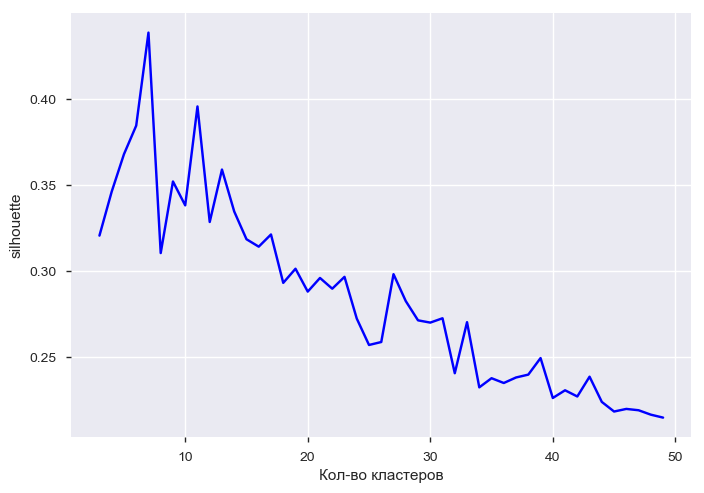

In [65]:
scores = [silhouetteScore(X, n_clusters) for n_clusters in range_n_clusters]

plt.plot(range_n_clusters, scores,'b')
plt.xlabel(u'Кол-во кластеров')
plt.ylabel(u'silhouette')

In [66]:
for x,y in zip(range_n_clusters,scores):
    print (x,y)

3 0.320680794623
4 0.346202739015
5 0.367911930973
6 0.384488829444
7 0.438474697589
8 0.310552778388
9 0.352089836483
10 0.338228627454
11 0.395639006735
12 0.328593129687
13 0.359001275204
14 0.334668646856
15 0.318576648417
16 0.314266109226
17 0.321343327702
18 0.293260981589
19 0.301454970476
20 0.288195463413
21 0.296106131897
22 0.289884446986
23 0.296754112476
24 0.272554580499
25 0.257219549202
26 0.258933824148
27 0.29830347762
28 0.282686471446
29 0.271515207071
30 0.270200702632
31 0.27272282787
32 0.240840380869
33 0.27044734757
34 0.232630265546
35 0.237934583174
36 0.235157590488
37 0.238359635234
38 0.240021285728
39 0.249623490339
40 0.226460780333
41 0.230927753053
42 0.227334074882
43 0.238817081257
44 0.224178189078
45 0.218605116456
46 0.220114536943
47 0.219346718443
48 0.216782199636
49 0.215073396601


In [67]:
agg = KMeans(n_clusters=7)

agg.fit(X)
labels = agg.labels_

In [68]:
df_full1['labels'] = labels

In [69]:
df_full1['labels'].value_counts()

5    41
6    30
0    27
2     6
4     5
1     5
3     4
Name: labels, dtype: int64

In [70]:
df_final2 = df_final
df_final2['labels'] = labels

In [71]:
df_cluster1 = df_final2[df_final2['labels'] ==5]

In [72]:
pp.ProfileReport(df_cluster1)

Number of variables,16
Number of observations,41
Total Missing (%),0.0%
Total size in memory,5.0 KiB
Average record size in memory,126.0 B
Numeric,13
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,2


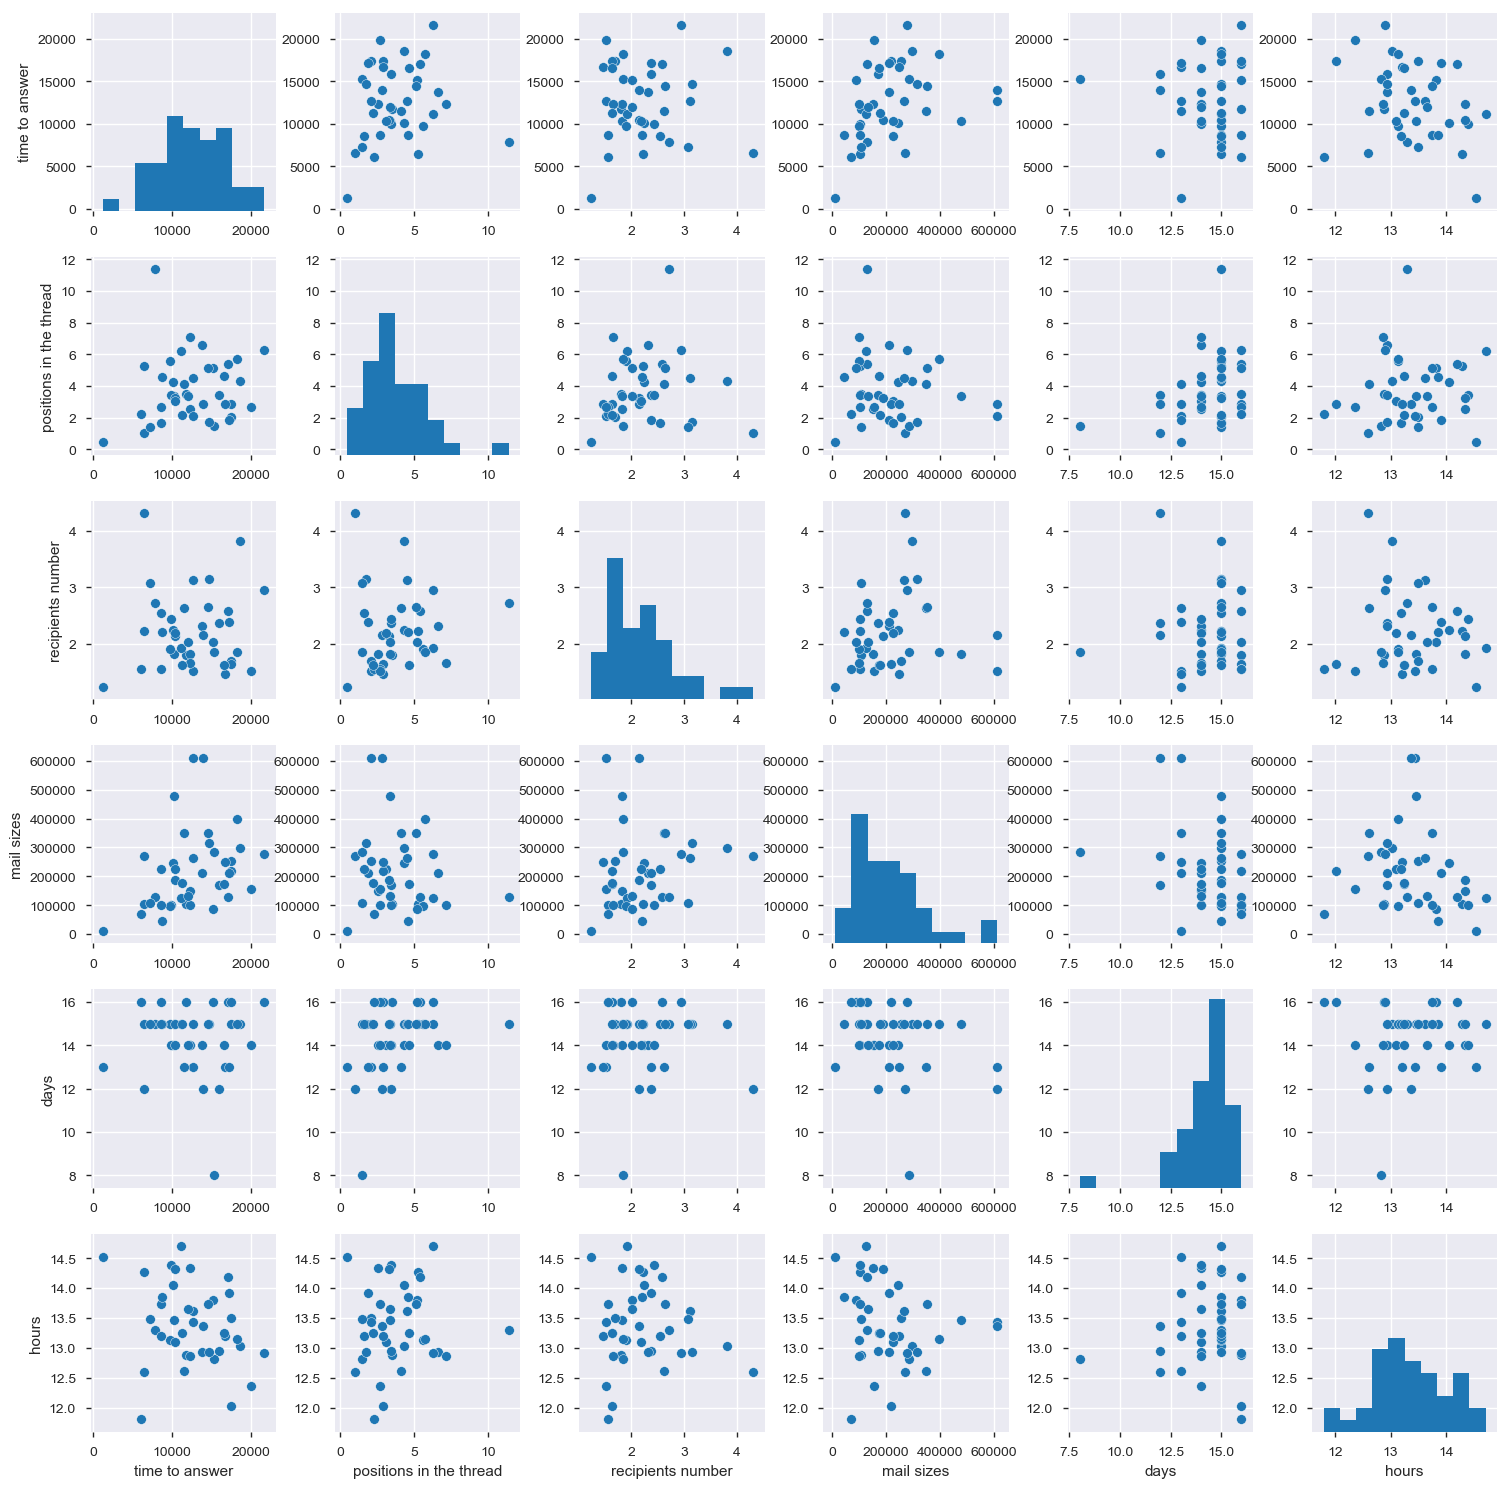

In [73]:
import seaborn as sns
sns.pairplot(df_cluster1[['time to answer' ,
    'positions in the thread' ,
    'recipients number',
    'mail sizes','days','hours']])

In [74]:
df_cluster2 = df_final2[df_final2['labels'] ==6]

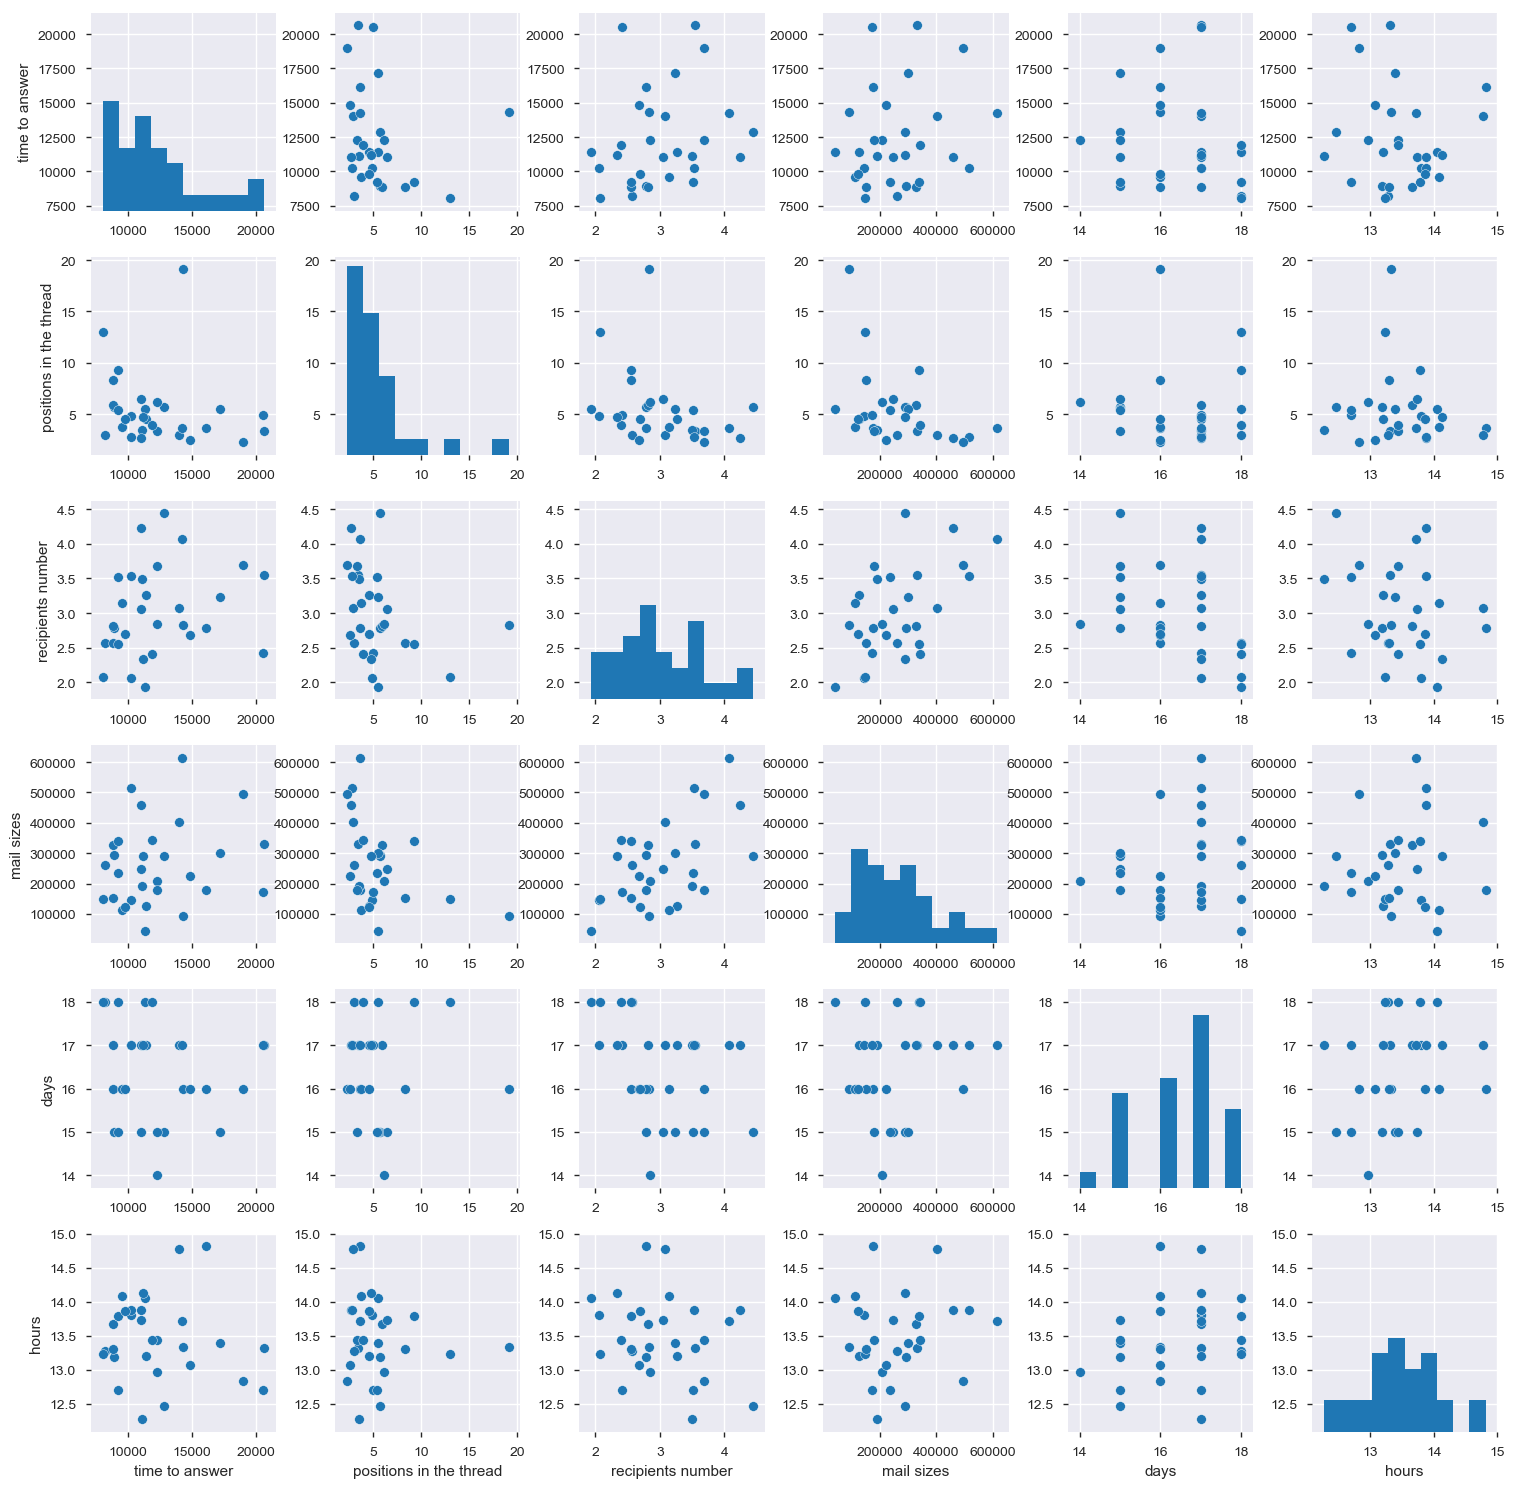

In [75]:
sns.pairplot(df_cluster2[['time to answer' ,
    'positions in the thread' ,
    'recipients number',
    'mail sizes','days','hours']])